# Import libraries

In [ ]:
!pip install rlssm
import rlssm
import numpy as np
import copy
import pickle
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pystan
import arviz as az
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "drive/MyDrive/CMPLabData/Lexicon/"

# Prepare data

In [ ]:
words = []
frq = []
sum_frq = 0
with open(root+"Datasets/Items.csv", 'r') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx ==0 or len(row[0]) > 20: 
            continue
        words.append([row[0], int(row[2].replace(',',''))])
        frq.append(int(row[2].replace(',','')))
        sum_frq += int(row[2].replace(',',''))
        
words.sort(key = lambda x: x[1], reverse=True)

all_words = [word[0] for word in words]
hf_words = all_words[:int(len(words)/2)]
lf_words = all_words[int(len(words)/2):]
# Another metric for defining hf an lf is good to be tested (something other than half of the words are hf
# and other half is lf)

In [ ]:
word_nword_df = pd.read_csv(root+"Datasets/full_dataset_prob_a.csv", header=None, names =['string', 'freq',  'label', 'log_freq','category', 'word_prob', 'non_word_prob', 'logit'])

word_nword_df

,string,freq,label,log_freq,category,word_prob,non_word_prob,logit
0,a,10610626,1,16.0,HF,0.906281,0.093719,2.269047
1,aah,222,1,5.0,LF,0.602188,0.397813,0.414588
2,Aaron,10806,1,9.0,HF,0.847060,0.152940,1.711725
3,aback,387,1,6.0,LF,0.928595,0.071405,2.565301
4,abacus,513,1,6.0,LF,0.967652,0.032348,3.398307
...,...,...,...,...,...,...,...,...
80817,declassificarion,0,0,0.0,NW,0.207975,0.792025,-1.337176
80818,antifundamentadast,0,0,0.0,NW,0.008859,0.991141,-4.717467
80819,transcontanental,0,0,0.0,NW,0.032687,0.967313,-3.387558
80820,iv,0,0,0.0,NW,0.847766,0.152234,1.717187


In [ ]:
def categorise_by_log_freq(row, freq_rate=6):
    if row['string_type'] == 0:
        return 'NW'
    elif row['string_type'] == 1 and row['log_freq'] > freq_rate:
        return 'HF'
    elif row['string_type'] == 1 and (row['log_freq'] >= 0 and row['log_freq'] <=freq_rate):
        return 'LF'

In [ ]:
Number_Of_Trials = 500
behavioural_df = pd.read_csv(root+"behavioural/1DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
behavioural_df = behavioural_df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
convert_dict = {'string_type': 'int16',
                'accuracy': 'int16',
                'rt': float
               }

behavioural_df = behavioural_df.astype(convert_dict)
behavioural_df['rt'] = behavioural_df['rt'].apply(lambda x: x/1000) # convert to seconds

category = []
for index, row in tqdm(behavioural_df.iterrows()):
    if row['string_type']==0:
        category.append("NW")
    elif row['string'] in hf_words:
        category.append("HF")
    elif row['string'] in lf_words:
        category.append("LF")
        
# behavioural_df['category'] = category

# behavioural_df['string_type'] = behavioural_df['string_type'].replace(to_replace=[0], value=[2])
behavioural_df['accuracy'] = behavioural_df['accuracy'].replace(to_replace=[0], value=[-1])
behavioural_df = behavioural_df.reset_index(drop=True)

500it [00:00, 1695.79it/s]


In [ ]:
behavioural_df

,trial,string_type,accuracy,rt,string
0,1,1,-1,0.707,bookie
1,2,0,1,0.769,gandbrake
2,3,1,1,0.526,philosophical
3,4,0,-1,0.510,umbeaten
4,5,1,1,0.512,belonging
...,...,...,...,...,...
495,496,0,1,0.685,gelievers
496,497,1,1,0.483,watch
497,498,1,-1,0.756,grindings
498,499,0,1,0.574,hompromise


In [ ]:
type(word_nword_df)

pandas.core.frame.DataFrame

In [ ]:
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)

# After the merge there are some NaN's probably becuase word_nword_df is are trainset that is 0.8 of
# All our lexical data
# It's good to be tested with full data (prediction of ANN on all lexical data)

In [ ]:
behavioural_df

,trial,string_type,accuracy,rt,string,freq,label,log_freq,category,word_prob,non_word_prob,logit
0,1,1,-1,0.707,bookie,130,1,5.0,LF,0.989037,0.010963,4.502175
1,2,0,1,0.769,gandbrake,0,0,0.0,NW,0.012977,0.987023,-4.331480
2,3,1,1,0.526,philosophical,4959,1,9.0,HF,0.987289,0.012711,4.352460
3,4,0,-1,0.510,umbeaten,0,0,0.0,NW,0.382299,0.617701,-0.479800
4,5,1,1,0.512,belonging,2332,1,8.0,LF,0.983846,0.016154,4.109307
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0,1,0.685,gelievers,0,0,0.0,NW,0.008664,0.991336,-4.739919
496,497,1,1,0.483,watch,56974,1,11.0,HF,0.923770,0.076230,2.494713
497,498,1,-1,0.756,grindings,4,1,2.0,LF,0.822219,0.177781,1.531453
498,499,0,1,0.574,hompromise,0,0,0.0,NW,0.055176,0.944824,-2.840468


In [ ]:
behavioural_df.groupby('category').count()

,trial,string_type,accuracy,rt,string,freq,label,log_freq,word_prob,non_word_prob,logit
category,,,,,,,,,,,
HF,39,39,39,39,39,39,39,39,39,39,39
LF,218,218,218,218,218,218,218,218,218,218,218
NW,243,243,243,243,243,243,243,243,243,243,243


In [ ]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count'], 'non_word_prob': ['mean', 'std', 'count'],
                                  'logit': ['mean', 'std', 'count']})

word_prob                 non_word_prob                     logit  \
              mean       std count          mean       std count      mean   
category                                                                     
HF        0.928299  0.128227    39      0.071701  0.128227    39  3.843487   
LF        0.850552  0.208267   218      0.149448  0.208267   218  2.674047   
NW        0.164332  0.252289   243      0.835668  0.252289   243 -2.741229   

                          
               std count  
category                  
HF        1.857113    39  
LF        1.870452   218  
NW        2.268299   243

# NN Stan

In [ ]:
ann_ddm_model = pystan.StanModel(file='single.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af9e60bbb72398580d53847644e409e6 NOW.


In [ ]:
behavioural_df.iloc[0, [9, 10]].to_numpy() + 0.001   

array([0.9900366, 0.011963330000000001], dtype=object)

In [ ]:
N = len(behavioural_df)                                       
x = behavioural_df.iloc[:, [9, 10]].to_numpy() + 0.001                         # Feature data
frequencies = behavioural_df['freq'].to_numpy() + 1             
rt = behavioural_df['rt'].to_numpy()                      
accuracy = behavioural_df['accuracy'].to_numpy().astype(int)

# word_coefficient_priors = [0, 1]
# nword_coefficient_priors = [2, 1]    
drift_scaling_priors = [2, 1]                                          # mean and sd of the prior
threshold_priors = [5, 3]                                                     # mean and sd of the prior
ndt_priors = [0, 0.3] 
# bias_priors =  [2, 1]  
starting_point = 0.5

# define input for the model
data_dict = {'N': N,
             'x' : x, 
             'frequencies': frequencies,                                                                    
             'rt': rt,
             'accuracy': accuracy,
            #  'word_coefficient_priors': word_coefficient_priors,
            #  'nword_coefficient_priors' : nword_coefficient_priors,                                    
             'threshold_priors' : threshold_priors,                                                
             'ndt_priors':ndt_priors,
            #  'bias_priors':bias_priors,
             'starting_point': starting_point,
             'drift_scaling_priors' : drift_scaling_priors
            }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_chains = 4

In [ ]:
# fit the model
fit = ann_ddm_model.sampling(data=data_dict,
                             iter=n_iter, 
                             warmup=n_warmup,
                             chains=n_chains,
                             verbose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
print("***hmc diagnostics:")
print(pystan.check_hmc_diagnostics(fit))

***hmc diagnostics:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

print("***DF: ")
print(df)

***DF: 
                            mean   se_mean        sd        2.5%         25%  \
drift_scaling          -1.966485  0.002882  0.106657   -2.189315   -2.033603   
threshold               0.767585  0.000967  0.036011    0.699622    0.742257   
ndt                    -0.714305  0.000188  0.007263   -0.730175   -0.718925   
drift_ll[1]            -1.222624  0.003243  0.120811   -1.464934   -1.303171   
drift_ll[2]            -0.560349  0.001487  0.055370   -0.671403   -0.597265   
...                          ...       ...       ...         ...         ...   
ndt_t[500]              0.398468  0.000062  0.002385    0.393274    0.396946   
transf_drift_scaling    0.131591  0.000349  0.013003    0.106154    0.122981   
transf_threshold        1.148988  0.000661  0.024597    1.102934    1.131619   
transf_ndt              0.398468  0.000062  0.002385    0.393274    0.396946   
lp__                 -101.690582  0.038148  1.214822 -104.848304 -102.295956   

                             50

In [ ]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["Rhat"]:
    if f > 1.01:
        # print(f)
        counter+=1
print(counter)

***Rhat > 1.01: 
0


In [ ]:
df.loc[df['Rhat']>1.01].describe()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
with open(root+"results/model_fit.pkl", "wb") as f:
    pickle.dump({'model' : ann_ddm_model, 'fit' : fit}, f, protocol=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


# Check parameters

In [ ]:
with open(root+"results/model_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc404ee66d0>,
      dtype=object)

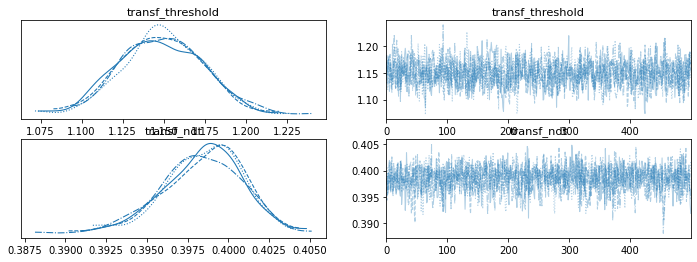

In [ ]:
az.plot_trace(fit, var_names=['transf_threshold', 'transf_ndt'])

In [ ]:
fit_result_df = fit.to_dataframe(pars=['transf_drift_scaling', 'transf_threshold', 'transf_ndt'],
                 diagnostics=False, inc_warmup=False).drop(['chain','draw', 'warmup'], axis=1)

In [ ]:
fit_result_df

,transf_drift_scaling,transf_ndt,transf_threshold
0,0.121020,0.397449,1.182703
1,0.149372,0.398420,1.145242
2,0.112739,0.395467,1.173127
3,0.125395,0.395858,1.157167
4,0.143626,0.399511,1.181658
...,...,...,...
1995,0.137653,0.400274,1.141382
1996,0.132196,0.401059,1.123595
1997,0.138727,0.396133,1.180817
1998,0.142582,0.396707,1.189208


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc40692cbd0>,
      dtype=object)

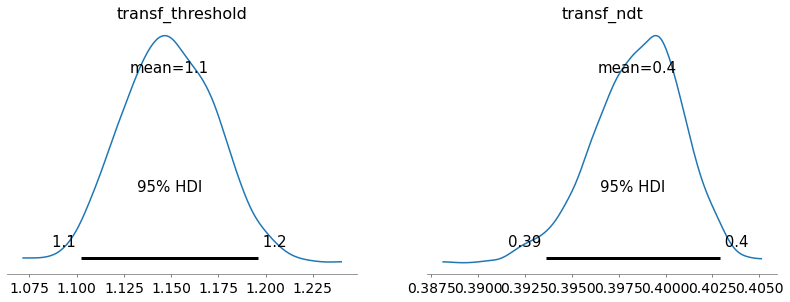

In [ ]:
az.plot_posterior(fit, var_names=['transf_threshold', 'transf_ndt'], hdi_prob=.95)

In [ ]:
drift_t = fit['drift_t']
threshold_t = fit['threshold_t']
ndt_t = fit['ndt_t']

In [ ]:
HF_condition = drift_t[:, behavioural_df.index[behavioural_df['category']=="HF"].tolist()]
LF_condition = drift_t[:, behavioural_df.index[behavioural_df['category']=="LF"].tolist()]
NW_condition = drift_t[:, behavioural_df.index[behavioural_df['category']=="NW"].tolist()]

In [ ]:
print('HF words drifts mean and std:')
np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1))

HF words drifts mean and std:


(1.7932913944030269, 0.17715658721331484)

In [ ]:
print('LF words drifts mean and std:')
np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1))

LF words drifts mean and std:


(1.0573205375300154, 0.10445112188904446)

In [ ]:
print('Non Words drifts mean and std:')
np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1))

Non Words drifts mean and std:


(-0.34977736242531376, 0.03455398492690092)

# Posterior Predictions

In [ ]:
rt, response = rlssm.random.random_ddm(drift=drift_t, threshold=threshold_t, rel_sp=0.5, ndt=ndt_t, max_rt=10)

In [ ]:
word_rt = rt[:, behavioural_df['label']==1]
hf_word_rt = rt[:, behavioural_df['category']=="HF"]
lf_word_rt = rt[:, behavioural_df['category']=="LF"]
nword_rt = rt[:, behavioural_df['label']==0]

word_data_rt_mean = np.mean(behavioural_df.loc[behavioural_df['label']==1]['rt'])
hf_word_data_rt_mean = np.mean(behavioural_df.loc[behavioural_df['category']=='HF']['rt'])
lf_word_data_rt_mean = np.mean(behavioural_df.loc[behavioural_df['category']=='LF']['rt'])
nword_data_rt_mean = np.mean(behavioural_df.loc[behavioural_df['label']==0]['rt'])

In [ ]:
word_acc = []
hf_word_acc = []
lf_word_acc = []
nword_acc = []


for index in tqdm(range(response.shape[0])):
    sample_acc = response[index,  behavioural_df['label']==1] == behavioural_df.loc[behavioural_df['label']==1]['string_type']
    word_acc.append(np.mean(sample_acc))
    
for index in tqdm(range(response.shape[0])):
    sample_acc = response[index,  behavioural_df['category']=='HF'] == behavioural_df.loc[behavioural_df['category']=='HF']['string_type']
    hf_word_acc.append(np.mean(sample_acc))
    
for index in tqdm(range(response.shape[0])):
    sample_acc = response[index,  behavioural_df['category']=='LF'] == behavioural_df.loc[behavioural_df['category']=='LF']['string_type']
    lf_word_acc.append(np.mean(sample_acc))
    
for index in tqdm(range(response.shape[0])):
    sample_acc = response[index,  behavioural_df['label']==0] == behavioural_df.loc[behavioural_df['label']==0]['string_type']
    nword_acc.append(np.mean(sample_acc))
    
word_acc = np.array(word_acc)
nword_acc = np.array(nword_acc)

word_data_acc_mean = np.mean(behavioural_df.loc[behavioural_df['label']==1]['accuracy'])
hf_word_data_acc_mean = np.mean(behavioural_df.loc[behavioural_df['category']=='HF']['accuracy'])
lf_word_data_acc_mean = np.mean(behavioural_df.loc[behavioural_df['category']=='LF']['accuracy'])
nword_data_acc_mean = np.mean(behavioural_df.loc[behavioural_df['label']==0]['accuracy'])

100%|██████████| 2000/2000 [00:02<00:00, 999.67it/s] 


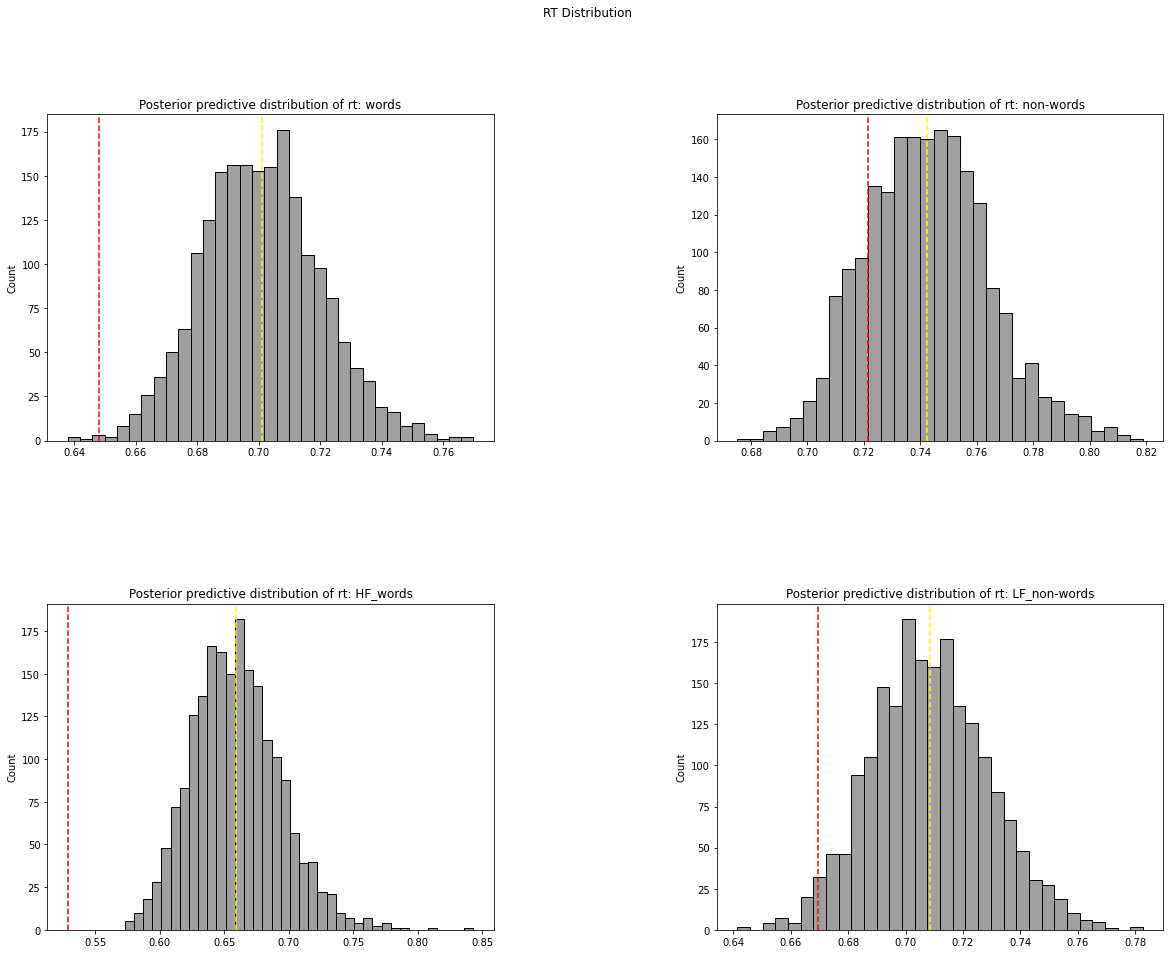

In [ ]:
fig, axes = plt.subplots(2,2 , figsize=(20,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('RT Distribution')
axes[0][0].set_title('Posterior predictive distribution of rt: words')
axes[0][1].set_title('Posterior predictive distribution of rt: non-words')
axes[1][0].set_title('Posterior predictive distribution of rt: HF_words')
axes[1][1].set_title('Posterior predictive distribution of rt: LF_non-words')

sns.histplot(ax=axes[0][0], data = np.mean(word_rt, axis=1), color='grey')
axes[0][0].axvline(word_data_rt_mean, color='red', linestyle='--');
axes[0][0].axvline(np.mean(np.mean(word_rt)), color='yellow', linestyle='--');

sns.histplot(ax=axes[0][1], data = np.mean(nword_rt, axis=1), color='grey')
axes[0][1].axvline(nword_data_rt_mean, color='red', linestyle='--');
axes[0][1].axvline(np.mean(np.mean(nword_rt, axis=1)), color='yellow', linestyle='--');

sns.histplot(ax=axes[1][0], data = np.mean(hf_word_rt, axis=1), color='grey')
axes[1][0].axvline(hf_word_data_rt_mean, color='red', linestyle='--');
axes[1][0].axvline(np.mean(np.mean(hf_word_rt)), color='yellow', linestyle='--');

sns.histplot(ax=axes[1][1], data = np.mean(lf_word_rt, axis=1), color='grey')
axes[1][1].axvline(lf_word_data_rt_mean, color='red', linestyle='--');
axes[1][1].axvline(np.mean(np.mean(lf_word_rt, axis=1)), color='yellow', linestyle='--');

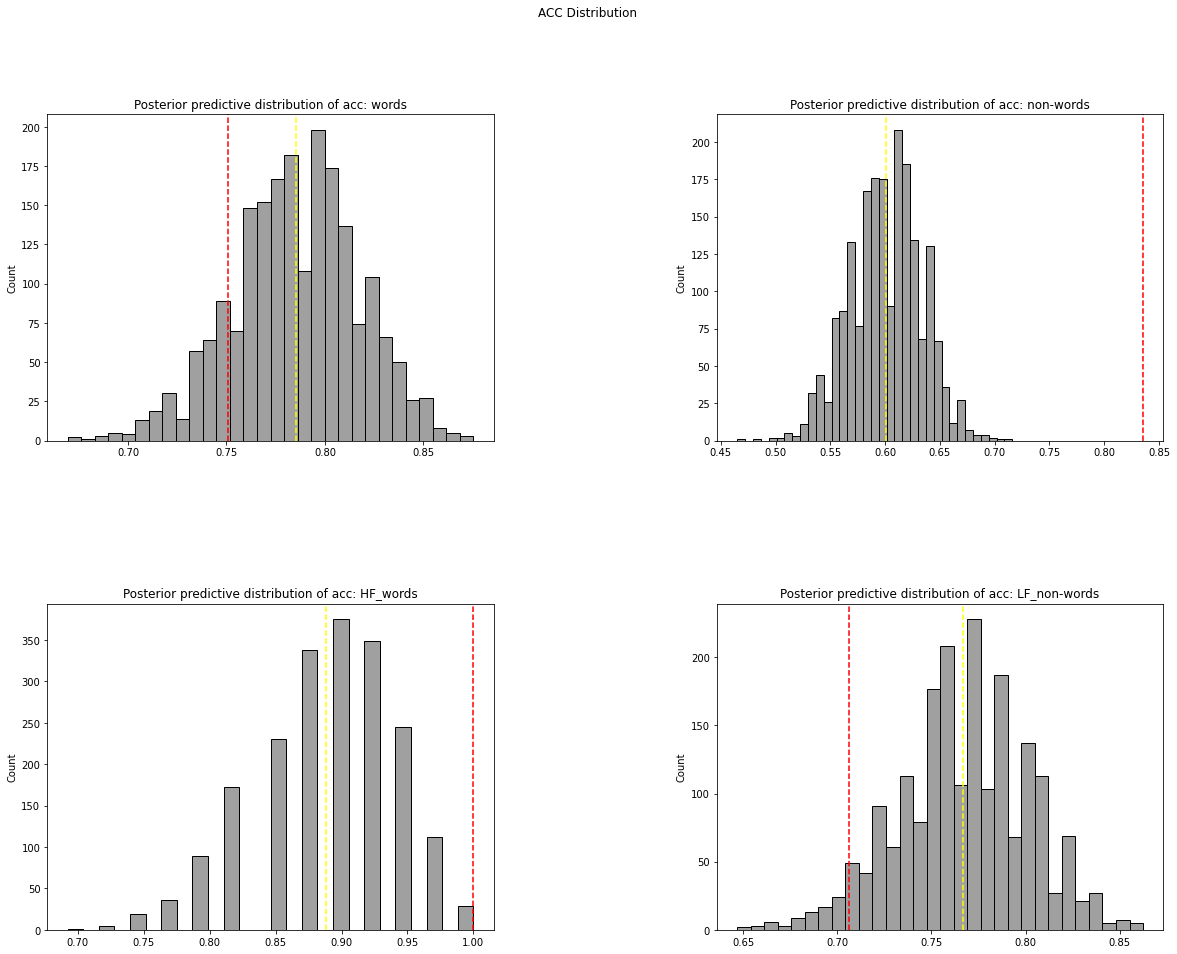

In [ ]:
fig, axes = plt.subplots(2,2 , figsize=(20,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('ACC Distribution')
axes[0][0].set_title('Posterior predictive distribution of acc: words')
axes[0][1].set_title('Posterior predictive distribution of acc: non-words')
axes[1][0].set_title('Posterior predictive distribution of acc: HF_words')
axes[1][1].set_title('Posterior predictive distribution of acc: LF_non-words')

sns.histplot(ax=axes[0][0], data = word_acc, color='grey')
axes[0][0].axvline(word_data_acc_mean, color='red', linestyle='--');
axes[0][0].axvline(np.mean(word_acc), color='yellow', linestyle='--');

sns.histplot(ax=axes[0][1], data = nword_acc, color='grey')
axes[0][1].axvline(nword_data_acc_mean, color='red', linestyle='--');
axes[0][1].axvline(np.mean(nword_acc), color='yellow', linestyle='--');

sns.histplot(ax=axes[1][0], data = hf_word_acc, color='grey')
axes[1][0].axvline(hf_word_data_acc_mean, color='red', linestyle='--');
axes[1][0].axvline(np.mean(hf_word_acc), color='yellow', linestyle='--');

sns.histplot(ax=axes[1][1], data = lf_word_acc, color='grey')
axes[1][1].axvline(lf_word_data_acc_mean, color='red', linestyle='--');
axes[1][1].axvline(np.mean(lf_word_acc), color='yellow', linestyle='--');


# Quantile Data

In [ ]:
words_rt_real = behavioural_df.loc[behavioural_df['label']==1]['rt']
hf_words_rt_real = behavioural_df.loc[behavioural_df['category']=="HF"]['rt']
lf_words_rt_real = behavioural_df.loc[behavioural_df['category']=="LF"]['rt']
non_words_rt_real = behavioural_df.loc[behavioural_df['label']==0]['rt']

## Words Quantiles

In [ ]:
words_data_dic = {'predicted_rt':np.mean(word_rt, axis=0), 'predicted_quantiles':["None"]*len(words_rt_real),
           'real_rt': words_rt_real, 'real_quantiles':["None"]*len(words_rt_real)}
words_data = pd.DataFrame(data=words_data_dic)

bin_labels= ["0.1", "0.3", "0.5", "0.7", "0.9", "1"]
words_data['real_quantiles'] = pd.qcut(words_data['real_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)
words_data['predicted_quantiles'] = pd.qcut(words_data['predicted_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)

In [ ]:
words_data

,predicted_rt,predicted_quantiles,real_rt,real_quantiles
0,0.699081,0.5,0.707,0.9
2,0.664731,0.3,0.526,0.3
4,0.678569,0.3,0.512,0.3
5,0.703004,0.5,0.626,0.7
7,0.685069,0.3,0.846,0.9
...,...,...,...,...
492,0.745063,1,0.653,0.7
494,0.651216,0.1,0.527,0.3
496,0.667810,0.3,0.483,0.1
497,0.727087,0.9,0.756,0.9


In [ ]:
real_rt = []
predicted_rt = []

real_rt.append(np.mean(words_data.loc[words_data['real_quantiles']=='0.1']['real_rt']))
real_rt.append(np.mean(words_data.loc[words_data['real_quantiles']=='0.3']['real_rt']))
real_rt.append(np.mean(words_data.loc[words_data['real_quantiles']=='0.5']['real_rt']))
real_rt.append(np.mean(words_data.loc[words_data['real_quantiles']=='0.7']['real_rt']))
real_rt.append(np.mean(words_data.loc[words_data['real_quantiles']=='0.9']['real_rt']))

predicted_rt.append(np.mean(words_data.loc[words_data['predicted_quantiles']=='0.1']['predicted_rt']))
predicted_rt.append(np.mean(words_data.loc[words_data['predicted_quantiles']=='0.3']['predicted_rt']))
predicted_rt.append(np.mean(words_data.loc[words_data['predicted_quantiles']=='0.5']['predicted_rt']))
predicted_rt.append(np.mean(words_data.loc[words_data['predicted_quantiles']=='0.7']['predicted_rt']))
predicted_rt.append(np.mean(words_data.loc[words_data['predicted_quantiles']=='0.9']['predicted_rt']))

In [ ]:
words_quantiles_dic = {'Real':real_rt, 'Predicted': predicted_rt}
words_quantiles = pd.DataFrame(data=words_quantiles_dic)

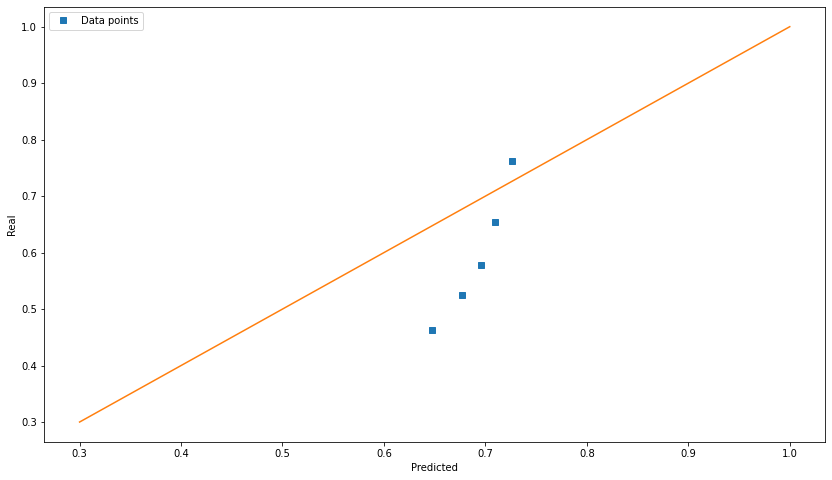

In [ ]:
x=np.linspace(0.3, 1, 100)
y = x
# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(words_quantiles['Predicted'], words_quantiles['Real'], linewidth=0, marker='s', label='Data points')
ax.plot(x, y)
ax.set_xlabel('Predicted')
ax.set_ylabel('Real')
ax.legend(facecolor='white')

## HF Quantiles

In [ ]:
HF_data_dic = {'predicted_rt':np.mean(hf_word_rt, axis=0), 'predicted_quantiles':["None"]*len(hf_words_rt_real),
           'real_rt': hf_words_rt_real, 'real_quantiles':["None"]*len(hf_words_rt_real)}
HF_data = pd.DataFrame(data=HF_data_dic)

bin_labels= ["0.1", "0.3", "0.5", "0.7", "0.9", "1"]
HF_data['real_quantiles'] = pd.qcut(HF_data['real_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)
HF_data['predicted_quantiles'] = pd.qcut(HF_data['predicted_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)

In [ ]:
real_rt = []
predicted_rt = []

real_rt.append(np.mean(HF_data.loc[HF_data['real_quantiles']=='0.1']['real_rt']))
real_rt.append(np.mean(HF_data.loc[HF_data['real_quantiles']=='0.3']['real_rt']))
real_rt.append(np.mean(HF_data.loc[HF_data['real_quantiles']=='0.5']['real_rt']))
real_rt.append(np.mean(HF_data.loc[HF_data['real_quantiles']=='0.7']['real_rt']))
real_rt.append(np.mean(HF_data.loc[HF_data['real_quantiles']=='0.9']['real_rt']))

predicted_rt.append(np.mean(HF_data.loc[HF_data['predicted_quantiles']=='0.1']['predicted_rt']))
predicted_rt.append(np.mean(HF_data.loc[HF_data['predicted_quantiles']=='0.3']['predicted_rt']))
predicted_rt.append(np.mean(HF_data.loc[HF_data['predicted_quantiles']=='0.5']['predicted_rt']))
predicted_rt.append(np.mean(HF_data.loc[HF_data['predicted_quantiles']=='0.7']['predicted_rt']))
predicted_rt.append(np.mean(HF_data.loc[HF_data['predicted_quantiles']=='0.9']['predicted_rt']))

In [ ]:
HF_quantiles_dic = {'Real':real_rt, 'Predicted': predicted_rt}
HF_quantiles = pd.DataFrame(data=HF_quantiles_dic)

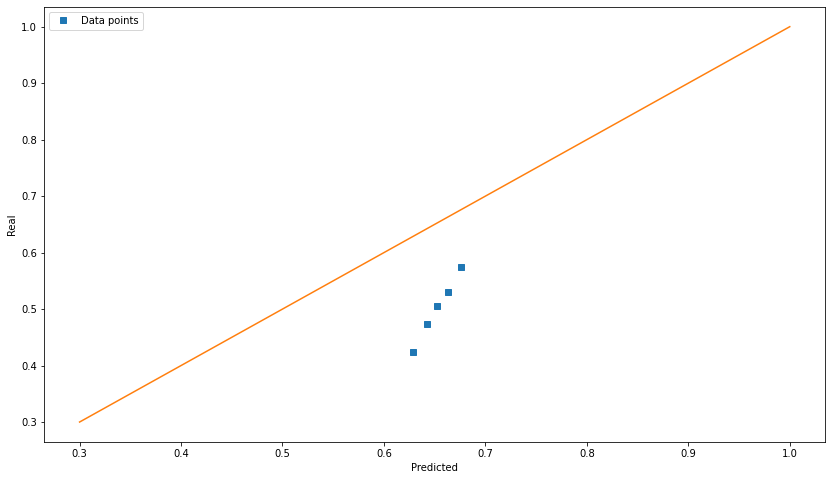

In [ ]:
x=np.linspace(0.3, 1, 100)
y = x
# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(HF_quantiles['Predicted'], HF_quantiles['Real'], linewidth=0, marker='s', label='Data points')
ax.plot(x, y)
ax.set_xlabel('Predicted')
ax.set_ylabel('Real')
ax.legend(facecolor='white')

## LF Quantiles

In [ ]:
LF_data_dic = {'predicted_rt':np.mean(lf_word_rt, axis=0), 'predicted_quantiles':["None"]*len(lf_words_rt_real),
           'real_rt': lf_words_rt_real, 'real_quantiles':["None"]*len(lf_words_rt_real)}
LF_data = pd.DataFrame(data=LF_data_dic)

bin_labels= ["0.1", "0.3", "0.5", "0.7", "0.9", "1"]
LF_data['real_quantiles'] = pd.qcut(LF_data['real_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)
LF_data['predicted_quantiles'] = pd.qcut(LF_data['predicted_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)

In [ ]:
real_rt = []
predicted_rt = []

real_rt.append(np.mean(LF_data.loc[LF_data['real_quantiles']=='0.1']['real_rt']))
real_rt.append(np.mean(LF_data.loc[LF_data['real_quantiles']=='0.3']['real_rt']))
real_rt.append(np.mean(LF_data.loc[LF_data['real_quantiles']=='0.5']['real_rt']))
real_rt.append(np.mean(LF_data.loc[LF_data['real_quantiles']=='0.7']['real_rt']))
real_rt.append(np.mean(LF_data.loc[LF_data['real_quantiles']=='0.9']['real_rt']))

predicted_rt.append(np.mean(LF_data.loc[LF_data['predicted_quantiles']=='0.1']['predicted_rt']))
predicted_rt.append(np.mean(LF_data.loc[LF_data['predicted_quantiles']=='0.3']['predicted_rt']))
predicted_rt.append(np.mean(LF_data.loc[LF_data['predicted_quantiles']=='0.5']['predicted_rt']))
predicted_rt.append(np.mean(LF_data.loc[LF_data['predicted_quantiles']=='0.7']['predicted_rt']))
predicted_rt.append(np.mean(LF_data.loc[LF_data['predicted_quantiles']=='0.9']['predicted_rt']))

In [ ]:
LF_quantiles_dic = {'Real':real_rt, 'Predicted': predicted_rt}
LF_quantiles = pd.DataFrame(data=LF_quantiles_dic)

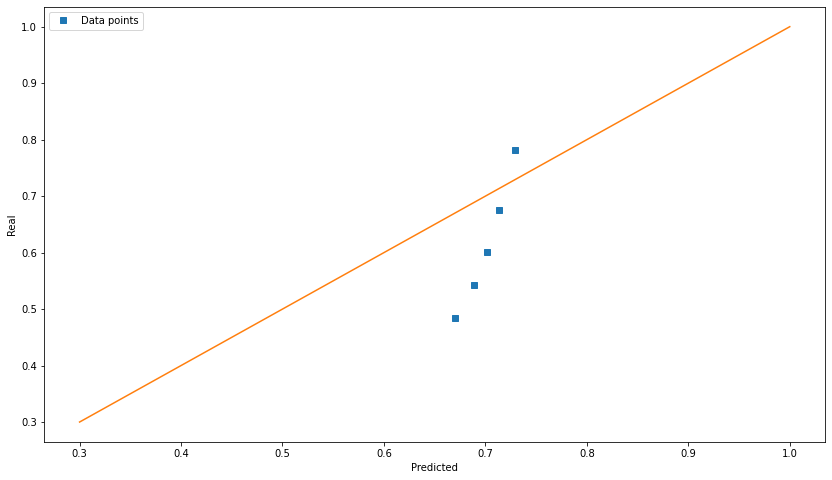

In [ ]:
x=np.linspace(0.3, 1, 100)
y = x
# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(LF_quantiles['Predicted'], LF_quantiles['Real'], linewidth=0, marker='s', label='Data points')
ax.plot(x, y)
ax.set_xlabel('Predicted')
ax.set_ylabel('Real')
ax.legend(facecolor='white')

## NW Quantiles

In [ ]:
NW_data_dic = {'predicted_rt':np.mean(nword_rt, axis=0), 'predicted_quantiles':["None"]*len(non_words_rt_real),
           'real_rt': non_words_rt_real, 'real_quantiles':["None"]*len(non_words_rt_real)}
NW_data = pd.DataFrame(data=NW_data_dic)

bin_labels= ["0.1", "0.3", "0.5", "0.7", "0.9", "1"]
NW_data['real_quantiles'] = pd.qcut(NW_data['real_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)
NW_data['predicted_quantiles'] = pd.qcut(NW_data['predicted_rt'],
                                q=[0, .1, .3, .5, .7, .9, 1],
                                labels=bin_labels)

In [ ]:
real_rt = []
predicted_rt = []

real_rt.append(np.mean(NW_data.loc[NW_data['real_quantiles']=='0.1']['real_rt']))
real_rt.append(np.mean(NW_data.loc[NW_data['real_quantiles']=='0.3']['real_rt']))
real_rt.append(np.mean(NW_data.loc[NW_data['real_quantiles']=='0.5']['real_rt']))
real_rt.append(np.mean(NW_data.loc[NW_data['real_quantiles']=='0.7']['real_rt']))
real_rt.append(np.mean(NW_data.loc[NW_data['real_quantiles']=='0.9']['real_rt']))

predicted_rt.append(np.mean(NW_data.loc[NW_data['predicted_quantiles']=='0.1']['predicted_rt']))
predicted_rt.append(np.mean(NW_data.loc[NW_data['predicted_quantiles']=='0.3']['predicted_rt']))
predicted_rt.append(np.mean(NW_data.loc[NW_data['predicted_quantiles']=='0.5']['predicted_rt']))
predicted_rt.append(np.mean(NW_data.loc[NW_data['predicted_quantiles']=='0.7']['predicted_rt']))
predicted_rt.append(np.mean(NW_data.loc[NW_data['predicted_quantiles']=='0.9']['predicted_rt']))

In [ ]:
NW_quantiles_dic = {'Real':real_rt, 'Predicted': predicted_rt}
NW_quantiles = pd.DataFrame(data=NW_quantiles_dic)

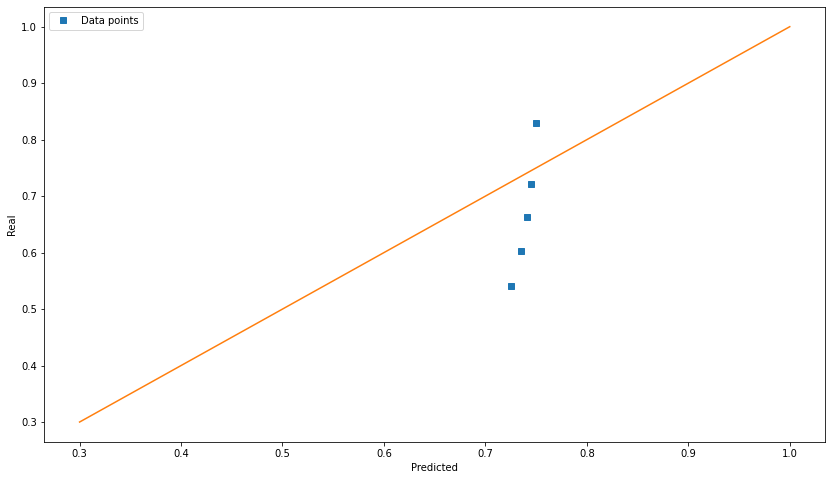

In [ ]:
x=np.linspace(0.3, 1, 100)
y = x
# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(NW_quantiles['Predicted'], NW_quantiles['Real'], linewidth=0, marker='s', label='Data points')
ax.plot(x, y)
ax.set_xlabel('Predicted')
ax.set_ylabel('Real')
ax.legend(facecolor='white')